In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [5]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch

In [78]:
train = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')
train

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


In [79]:
train['far_price'].fillna(0, inplace = True)
train['near_price'].fillna(0, inplace = True)
train.dropna(inplace = True)
train.reset_index(inplace = True)

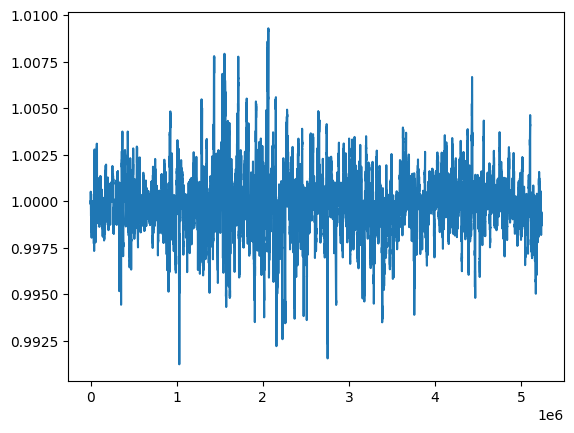

In [92]:
plt.plot(train[train['stock_id'] == 0]['wap'])
plt.show()

In [7]:
tester = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv')
tester

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,time_id,row_id,currently_scored
0,0,478,0,3753451.43,-1,0.999875,11548975.43,NaN,NaN,0.999875,22940.00,1.000050,9177.60,1.000000,26290,478_0_0,False
1,1,478,0,985977.11,-1,1.000245,3850033.97,NaN,NaN,0.999940,1967.90,1.000601,19692.00,1.000000,26290,478_0_1,False
2,2,478,0,599128.74,1,1.000584,4359198.25,NaN,NaN,0.999918,4488.22,1.000636,34955.12,1.000000,26290,478_0_2,False
3,3,478,0,2872317.54,-1,0.999802,27129551.64,NaN,NaN,0.999705,16082.04,1.000189,10314.00,1.000000,26290,478_0_3,False
4,4,478,0,740059.14,-1,0.999886,8880890.78,NaN,NaN,0.999720,19012.35,1.000107,7245.60,1.000000,26290,478_0_4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32995,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,26454,480_540_195,False
32996,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,26454,480_540_196,False
32997,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,26454,480_540_197,False
32998,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,26454,480_540_198,False


In [93]:
tester['far_price'].fillna(0, inplace = True)
tester['near_price'].fillna(0, inplace = True)
tester.dropna(inplace = True)
tester.reset_index(inplace = True)

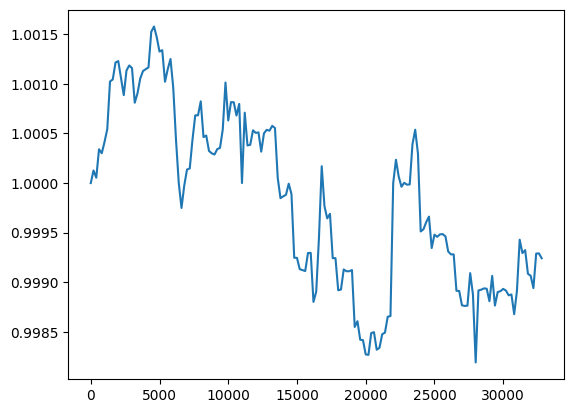

In [94]:
plt.plot(tester[tester['stock_id'] == 0]['wap'])
plt.show()

In [8]:
feature_list = ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price',
               'matched_size', 'bid_price', 'ask_price', 'ask_size', 'wap']

In [70]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        
        self.input = torch.nn.Linear(input_dim, 32)
        self.hidden = torch.nn.Linear(32, 8)
        self.output = torch.nn.Linear(8, 1)

    def forward(self, x):
        features = self.input(x)
        
        features = self.hidden(features)
        
        return self.output(features)

net = NeuralNetwork(len(feature_list))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

In [81]:
X = train.drop('target', axis=1)  # Features
y = train['target']  # Target variable

X["imbalance_size"] = np.log10(X["imbalance_size"]+1)
X["matched_size"] = np.log10(X["matched_size"]+1)
X["bid_size"] = np.log10(X["bid_size"]+1)
X["ask_size"] = np.log10(X["ask_size"]+1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [74]:
from tqdm import tqdm

In [85]:
BATCHSIZE = 16000

for batch in tqdm(range(0, len(X_train), BATCHSIZE)):
    optimizer.zero_grad()
    preds = net(torch.FloatTensor(np.array(X_train[feature_list][batch:batch+BATCHSIZE])))
    loss = criterion(preds, torch.FloatTensor(np.array(y_train[batch:batch+BATCHSIZE]).reshape(-1, 1)))

    loss.backward()
    optimizer.step

print(loss)

100%|██████████| 262/262 [00:43<00:00,  5.99it/s]

tensor(116.6820, grad_fn=<MseLossBackward0>)


In [90]:
y_train_pred = net(torch.FloatTensor(np.array(X_train[feature_list]))).detach().numpy()
y_test_pred = net(torch.FloatTensor(np.array(X_test[feature_list]))).detach().numpy()

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f'Training Set:')
print(f'Mean Absolute Error (MAE): {mae_train}')

print(f'Test Set:')
print(f'Mean Absolute Error (MAE): {mae_test}')

Training Set:
Mean Absolute Error (MAE): 8.443011326529982
Test Set:
Mean Absolute Error (MAE): 8.157555936259763


In [91]:
mean_absolute_error(y_train, np.ones_like(y_train))

6.566495321564741